In [1]:
#importing the necessary dependencies

import numpy as np
import sys
import scipy
from numpy import array
caffe_root = '/path/to/caffe/'
sys.path.insert(0, caffe_root + 'python')
import caffe
from caffe.proto import caffe_pb2
from skimage import transform
import matplotlib.pyplot as plt
import cv2
import os
import math

%matplotlib inline

In [1]:
#initializing the model

#Specifying to use the GPU
caffe.set_mode_gpu()
caffe.set_device(0)

net = caffe.Classifier('../models/bvlc_googlenet/deploy.prototxt','../models/bvlc_googlenet/bvlc_googlenet.caffemodel',channel_swap=(2,1,0))
#BGR mean values
mean = np.array([103.939, 116.779, 123.68])

#To know the layer being backtracked
layer = ['conv2/3x3','pool2/3x3_s2','inception_3a','inception_3b','pool3/3x3_s2','inception_4a','inception_4b','inception_4c','inception_4d','inception_4e','pool4/3x3_s2','inception_5a','inception_5b']

NameError: name 'caffe' is not defined

In [5]:
#Member functions

#function to backtrack between two consecutive inception modules
def inc2inc(layer_in,layer_no,pool,out):
    #To keep track of the crops
	for cr in range(5):
		layer_out = []
        #If the current crop is being considered
		if layer_in[cr]!=-1:
			for values in layer_in[cr]:
                #To check if there is a pooling before the inception layer
				if pool:
					add = ''
				else:
					add = '/output'
                #Getting the ranges of each branch in the inception layer
				num_f1 = net.blobs[layer[layer_no]+'/1x1'].data.shape[1]
				num_f2 = net.blobs[layer[layer_no]+'/3x3'].data.shape[1]
				num_f3 = net.blobs[layer[layer_no]+'/5x5'].data.shape[1]
                #Checking if we need to take the 1x1 conv path
				if values[0] < num_f1:
                    #The weights of current layer corresponding to channel
					weights = net.params[layer[layer_no]+'/1x1'][0].data[values[0],:,0,0]
                    #Getting the blob data of previous layer
					data = net.blobs[layer[layer_no-1]+add].data[cr,:,values[1],values[2]]
                    #The most contributing position
					conv = np.argmax(data*weights)
					values = (conv, values[1],values[2])
                #Checking if we need to take the 3x3 conv path
				elif values[0] < num_f1+num_f2:
					weights = net.params[layer[layer_no]+'/3x3'][0].data[values[0]-num_f1,:,:,:]
					data = np.lib.pad(net.blobs[layer[layer_no]+'/3x3_reduce'].data[cr,:,:,:],1,'constant',constant_values=0)[1:-1,values[1]:values[1]+3,values[2]:values[2]+3]
					feature = np.argmax(np.sum(np.sum(data*weights,axis=2),axis=1))
					weights = net.params[layer[layer_no]+'/3x3_reduce'][0].data[feature,:,0,0]
					data = net.blobs[layer[layer_no-1]+add].data[cr,:,values[1],values[2]]
					conv = np.argmax(data*weights)
					values = (conv,values[1],values[2])
                #Checking if we need to take the 5x5 conv path
				elif values[0] < num_f1+num_f2+num_f3:
					weights = net.params[layer[layer_no]+'/5x5'][0].data[values[0]-num_f1-num_f2,:,:,:]
					data = np.lib.pad(net.blobs[layer[layer_no]+'/5x5_reduce'].data[cr,:,:,:],2,'constant',constant_values=0)[2:-2,values[1]:values[1]+5,values[2]:values[2]+5]
					feature = np.argmax(np.sum(np.sum(data*weights,axis=2),axis=1))
					weights = net.params[layer[layer_no]+'/5x5_reduce'][0].data[feature,:,0,0]
					data = net.blobs[layer[layer_no-1]+add].data[cr,:,values[1],values[2]]
					conv = np.argmax(data*weights)
					values = (conv,values[1],values[2])
                #Checking if we need to take the pool path
				else:	
					weights = net.params[layer[layer_no]+'/pool_proj'][0].data[values[0]-num_f1-num_f2-num_f3,:,0,0]
					data = net.blobs[layer[layer_no]+'/pool'].data[cr,:,values[1],values[2]]
					feature = np.argmax(data*weights)
					data = np.lib.pad(net.blobs[layer[layer_no-1]+add].data[cr,:,:,:],1,'constant',constant_values=0)[feature+1,values[1]:values[1]+3,values[2]:values[2]+3]
					x1, y1 = np.unravel_index(np.argmax(data), data.shape)
					values = (feature,values[1]+x1-1,values[2]+y1-1)
                #If the inception layer is preceeded by a pooling layer
				if pool:	
					x = (2*values[1], 2*values[1] + 3)
					y = (2*values[2], 2*values[2] + 3)
                    #Just to handle the naming of layers
					if out:
						x1, y1 = np.unravel_index(np.argmax(net.blobs[layer[layer_no-2]+'/output'].data[cr,values[0],x[0]:x[1],y[0]:y[1]]), net.blobs[layer[layer_no-2]+'/output'].data[cr,values[0],x[0]:x[1],y[0]:y[1]].shape)
					else:
						x1, y1 = np.unravel_index(np.argmax(net.blobs[layer[layer_no-2]].data[cr,values[0],x[0]:x[1],y[0]:y[1]]), net.blobs[layer[layer_no-2]].data[cr,values[0],x[0]:x[1],y[0]:y[1]].shape)
					layer_out.append((values[0],x[0]+x1,y[0]+y1))
				else:
					layer_out.append(values)
				layer_in[cr] = list(set(layer_out))
	return layer_in

#To backtrack from the loss layer upto the last inception module
def start(values):
    for cr in range(5):
        if values[cr]!=-1:
            weights = net.params['loss3/classifier'][0].data[values[cr]]
            data = net.blobs['pool5/7x7_s1'].data[cr,:,:,:]#nB 1024 1 1 
            conv = data[:,0,0]*weights
            num = np.sum(conv>0) # choosing all positive elements
            val = np.argsort(conv)[::-1][:num]
            layer_out = []
            for i in val:
                x, y = np.unravel_index(np.argmax(net.blobs['inception_5b/output'].data[cr,i,:,:]), [7,7])
                layer_out.append((i,x,y))
                values[cr] = layer_out
    return values

#To backtrack from the last conv layer 'conv2/3x3' to the first layer
def end(layer_in):
	for cr in range(5):
		if layer_in[cr]!=-1:
			layer_out = []
			for values in layer_in[cr]:
				weights = net.params['conv2/3x3'][0].data[values[0],:,:,:]
				data = np.lib.pad(net.blobs['conv2/3x3_reduce'].data[cr,:,:,:],1,'constant',constant_values=0)[1:-1,values[1]:values[1]+3,values[2]:values[2]+3]
				feature = np.argmax(np.sum(np.sum(data*weights,axis=2),axis=1))
				weights = net.params['conv2/3x3_reduce'][0].data[feature,:,0,0]
				data = net.blobs['pool1/3x3_s2'].data[cr,:,values[1],values[2]]
				feature = np.argmax(data*weights)
				x = (2*values[1], 2*values[1] + 3)
				y = (2*values[2], 2*values[2] + 3)
				x1, y1 = np.unravel_index(np.argmax(net.blobs['conv1/7x7_s2'].data[cr,feature,x[0]:x[1],y[0]:y[1]]), net.blobs['conv1/7x7_s2'].data[cr,feature,x[0]:x[1],y[0]:y[1]].shape)
				layer_out.append(((x[0]+x1)*2,(y[0]+y1)*2))# to get to image size
			layer_in[cr] = list(set(layer_out))
	return layer_in

def out_rem(pts, diag):
    values = pts
    neighbors = np.zeros((values.shape[0]))
    selPoints = np.empty((1,2))
    for i in range(values.shape[0]):
        diff = np.sqrt(np.sum(np.square(values-values[i]),axis=1))
        neighbors[i] = np.sum(diff<diag)
    for i in range(values.shape[0]):
        if neighbors[i]>0.05*values.shape[0]:
            selPoints = np.append(selPoints,values[i:i+1,:],axis=0)
    selPoints = selPoints[1:,:]
    selPoints = selPoints.astype(int)
    return selPoints

def heatmap(img, pts, sigma=20):
    k = (np.min(img.shape[:2])) if (np.min(img.shape[:2])%2==1) else (np.min(img.shape[:2])-1)
    mask = np.zeros(img.shape[:2])
    shape = mask.shape
    for i in range(pts.shape[0]):
        if pts[i,0]<shape[0] and pts[i,1]<shape[1]:
            mask[pts[i,0],pts[i,1]] += 1
    blur = cv2.GaussianBlur(mask,(k,k),sigma)
    blur = blur*255/np.max(blur)
    return blur

In [ ]:
#loading ilsvrc synset
synsets = open('ilsvrc_synsets.txt').readlines()

#Put the path to test image here
img_path = 'sample.jpg'
img=caffe.io.load_image(img_path)

#Preprocessing the image
resFac = 256.0/min(img.shape[:2])
newSize = map(int,(img.shape[0]*resFac,img.shape[1]*resFac))
img = transform.resize(img, newSize)
net.image_dims = newSize
#The offsets for the crops
inc = [[0,0],[0,newSize[1]-224],[newSize[0]-224,0],[newSize[0]-224,newSize[1]-224],[newSize[0]/2.0-112,newSize[1]/2.0-112]]
img = img*255.0
img[:,:,0]-=mean[2]
img[:,:,1]-=mean[1]
img[:,:,2]-=mean[0]
#Passing image through network
net.predict([img],oversample=True)
p = net.blobs['prob'].data
#The mean label
p_mean = np.argmax(np.mean(p,axis=0))
image_label = synsets[p_mean].split(',')[0]
image_label = image_label[image_label.index(' ')+1:]
crop_labels = [np.argmax(p[0]),np.argmax(p[1]),np.argmax(p[2]),np.argmax(p[3]),np.argmax(p[4])]
#To check if mean label does not match any crop
if p_mean in crop_labels:
	p_m = p_mean
else:
    p_m = crop_labels[4]
crops = []
#To check which crops to consider
for i in range(5):
    if np.argmax(p[i,:])==p_m:
        crops.append(1)
    else:
        crops.append(0)
values = [[],[],[],[],[]]
for cr in range(5):
    if crops[cr]==1:
				values[cr]=int(p_m)
    else:
				values[cr]=-1
#Calling the fuctions to backtract through the network
values = start(values)
values = inc2inc(values,12,0,1)
values = inc2inc(values,11,1,1)
values = inc2inc(values,9,0,1)
values = inc2inc(values,8,0,1)
values = inc2inc(values,7,0,1)
values = inc2inc(values,5,1,1)
values = inc2inc(values,3,0,1)
values = inc2inc(values,2,1,0)
values = end(values)
output = []
#To get the coordinates back to image size
for cr in range(5):
    if values[cr]!=-1:
        for i in values[cr]:
            output.append((int((i[0]+inc[cr][0])*(1/resFac)),int((i[1]+inc[cr][1])*(1/resFac))))

In [19]:
#Visualization
img = cv2.imread(img_path)
b,g,r = cv2.split(img)
img = cv2.merge((r,g,b))
diag = math.sqrt(img.shape[0]**2 + img.shape[1]**2)*0.1
values = np.asarray(output)
selPoints = out_rem(values, diag)
hm = heatmap(np.copy(img), selPoints)

_, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(img),ax[0].axis('off'),ax[0].set_title(image_label)
ax[1].imshow(img),ax[1].axis('off'),ax[1].scatter(selPoints[:,1],selPoints[:,0]),ax[1].set_title('CNN Fixations')
ax[2].imshow(img),ax[2].imshow(hm, alpha=0.6),ax[2].axis('off'),ax[2].set_title('Heatmap')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f0c62d17310>,
 (-0.5, 499.5, 375.5, -0.5),
 <matplotlib.text.Text at 0x7f0c614d3ad0>)

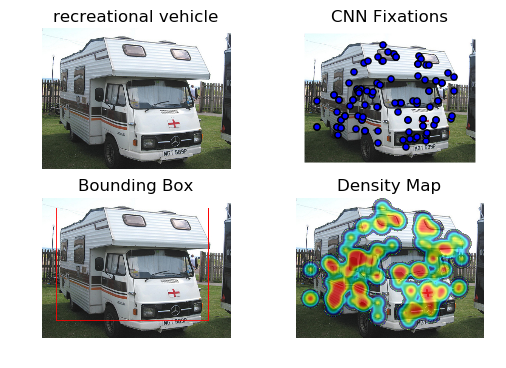

In [20]:
#Visualization

#Getting copy of Points
pts = np.copy(selPoints)
#Converting to image to rbg
b,g,r = cv2.split(img)
img = cv2.merge((r,g,b))
#Getting a bounding box
bbox = map(int,[min(selPoints[:,0]),min(selPoints[:,1]),max(selPoints[:,0]),max(selPoints[:,1])])
bb = toimage(img)
draw = ImageDraw.Draw(bb)
draw.rectangle(bbox,outline=(255,0,0))
#Getting a heatmap
hm = heatmap.Heatmap()
ar = ((0, 0), (img.shape[1],img.shape[0]))
si = (img.shape[1],img.shape[0])
ds = int(75*((img.shape[0]+img.shape[1])/875.0))
selPoints[:,1] = img.shape[0]-selPoints[:,1]
heatMap = hm.heatmap(selPoints,area= ar,size = si,dotsize = ds,opacity=500)
#To overlay on image
heatMap = np.asarray(heatMap)
indMap = heatMap[:,:,3]==0
heatMap = heatMap[:,:,0:3]
sup = cv2.addWeighted(img,0.4,heatMap,0.6,0)
sup[indMap] = img[indMap]

plt.subplot(221),plt.imshow(img),plt.axis('off'),plt.title(image_label)
plt.subplot(222),plt.imshow(img),plt.axis('off'),plt.scatter(pts[:,0],pts[:,1]),plt.title('CNN Fixations')
plt.subplot(223),plt.imshow(bb),plt.axis('off'),plt.title('Bounding Box')
plt.subplot(224),plt.imshow(sup),plt.axis('off'),plt.title('Density Map')


In [17]:
print p_mean

757
